# Use deep neural network to forecast seasonal time series data.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

1. Sythetic data generating.

In [2]:
# Generate synthetic seasonal data
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

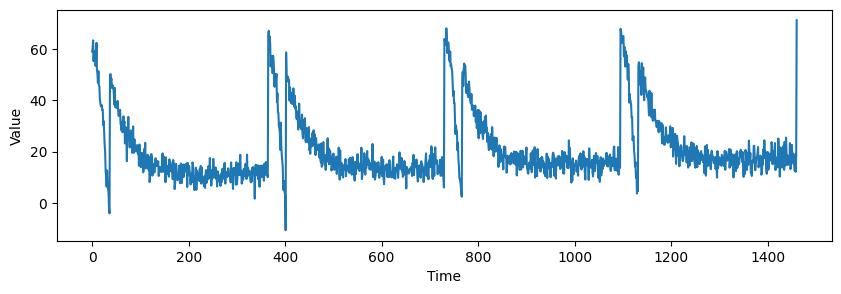

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)

    return time, series

# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

# Plot the generated series
plt.figure(figsize=(10, 3))
plot_series(G.TIME, G.SERIES)
plt.show()

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):

    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True )

    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)

    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

Model architecture design

In [6]:
def create_model(window_size=G.WINDOW_SIZE):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9))

    return model

In [7]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train the model
model.fit(dataset, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 8ms/step - loss: 162.9137
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 47.0399
Epoch 3/100
34/34 [==============================] - 0s 3ms/step - loss: 41.8981
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 37.4874
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 35.0103
Epoch 6/100
34/34 [==============================] - 0s 3ms/step - loss: 33.7382
Epoch 7/100
34/34 [==============================] - 0s 4ms/step - loss: 32.8125
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 31.8172
Epoch 9/100
34/34 [==============================] - 0s 4ms/step - loss: 31.6459
Epoch 10/100
34/34 [==============================] - 0s 5ms/step - loss: 30.8612
Epoch 11/100
34/34 [==============================] - 0s 5ms/step - loss: 29.9882
Epoch 12/100
34/34 [==============================] - 0s 3ms/step - loss: 30.1015
Epoch 13/100
34/34 [====

In [8]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

1/1 [==============================] - 0s 43ms/step


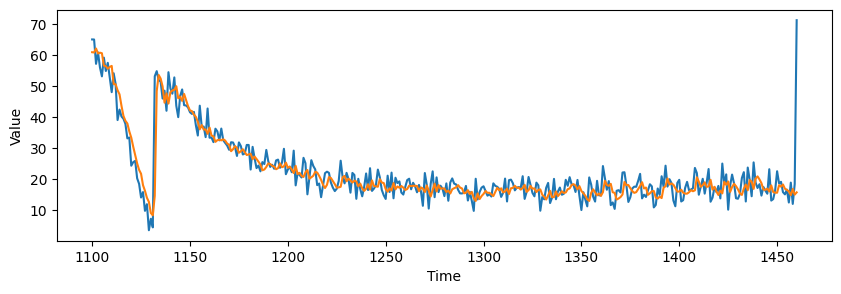

In [9]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 3))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

In [10]:
mse, mae = compute_metrics(series_valid, dnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 25.92, mae: 3.14 for forecast
